## 1.Load S&P data

In [1]:
import Loader as loader
from StockMarketInvestor import StockMarketInvestor

In [2]:
sp_comp = loader.get_sp_index()
print("S&P Companies")
sp_comp.head()

S&P Companies


,Company,Symbol,Weight,Price,Chg
0,Apple Inc.,AAPL,6.878571,167.80,0.40
1,Microsoft Corporation,MSFT,5.669560,286.89,1.59
2,Amazon.com Inc.,AMZN,3.668142,3092.00,-70.31
3,Tesla Inc,TSLA,2.281229,1028.40,0.25
4,Alphabet Inc. Class A,GOOGL,2.072692,2571.95,-28.23


In [3]:
#Peek at data
sp_hist = loader.get_ticker_historical(list(sp_comp["Symbol"]))
print("S&P Historical Data")
sp_hist[["AMZN","TSLA", "AAPL", "NFLX"]].tail()

S&P Historical Data


,AMZN,TSLA,AAPL,NFLX
Date,,,,
2022-03-24,3272.989990,1013.919983,174.070007,375.709991
2022-03-25,3295.469971,1010.640015,174.720001,373.850006
2022-03-28,3379.810059,1091.839966,175.600006,378.510010
2022-03-29,3386.300049,1099.569946,178.960007,391.820007
2022-03-30,3326.020020,1093.989990,177.770004,381.470001


In [4]:
print("S&P Historical Data statistical description")
sm_list = ["AMZN","TSLA", "AAPL", "NFLX"]
sp_hist_short = sp_hist[sm_list]
sp_hist_short.describe()

S&P Historical Data statistical description


,AMZN,TSLA,AAPL,NFLX
count,513.000000,513.000000,513.000000,513.000000
mean,3131.497037,623.689936,128.451540,507.627290
std,370.562331,284.574884,29.307192,76.135233
min,1846.089966,85.505997,56.092499,331.010010
25%,3057.159912,415.089996,115.050003,476.260010
50%,3217.010010,663.690002,129.639999,508.820007
75%,3355.729980,818.320007,148.759995,546.989990
max,3731.409912,1229.910034,182.009995,691.690002


## 2.Visualize Price and Monthly returns

<AxesSubplot:xlabel='Date'>

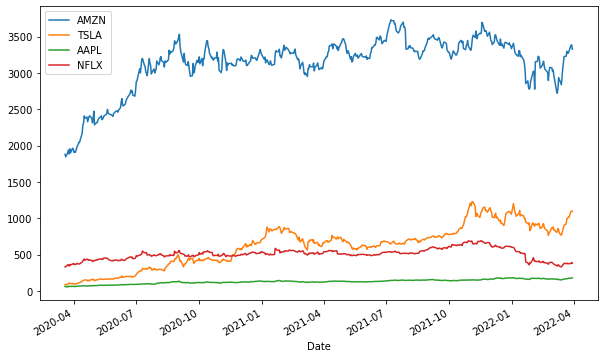

In [5]:
sp_hist_short.plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

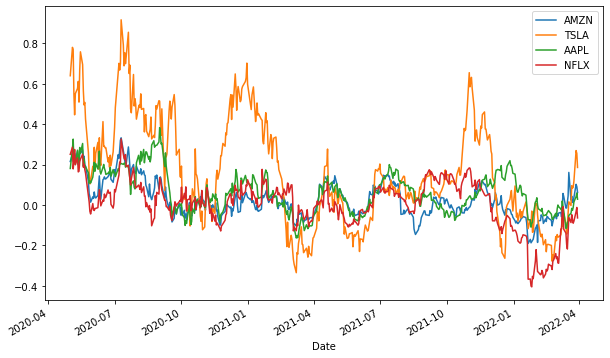

In [6]:
sp_hist_short.pct_change(30).dropna().plot(figsize=(10, 6))

<AxesSubplot:>

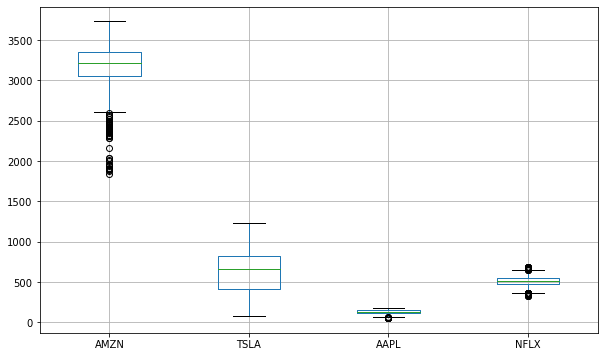

In [7]:
sp_hist_short.boxplot(figsize=(10, 6))

## 3. Run Stock Market Investor

### a) Run without constrains

In [ ]:
import warnings
warnings.filterwarnings("ignore")

sm = StockMarketInvestor(sp_hist, 0.1)
sm.train()

In [ ]:
ret = sm.optimize()

### b) Run with constrains include

In [ ]:
sm = StockMarketInvestor(sp_hist, 0.05, include=['AAPL'])
sm.train()

In [ ]:
ret = sm.optimize()

### b) Run with constrains include and exclude

In [ ]:
sm = StockMarketInvestor(sp_hist, 0.05, include=['AAPL'], exclude=['TSLA','FCX'])
sm.train()

In [ ]:
ret = sm.optimize()
ret = ret.merge(sp_comp, left_on='Symbol', right_on='Symbol')

In [ ]:
ret = ret.sort_values(by="InvestmentPercentage", ascending=False)

## USE LSTM To predict stock ticker, Can we make selections at individual level

In [ ]:
#choose top 4 stocks for prediction
sel_lst = list(ret["Symbol"][:5])
print(f"Choosen stocks: {sel_lst}")
sel_hist = sp_hist[sel_lst]

In [ ]:
sp_comp[sp_comp["Symbol"].isin(sel_hist)]

In [ ]:
mos = sel_hist["NVDA"].reset_index().drop(columns=["Date"])

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
mos = scaler.fit_transform(np.array(mos).reshape(-1,1))

In [ ]:
#split into training and test data splits
xtrs = int(len(mos)*0.65)
xtss = len(mos) - xtrs
train, test = mos[0:xtrs, :],  mos[xtrs:, :1]

In [ ]:
def create_features_targets(ds, time_step=1):
    X, y= [], []
    tf = len(ds)-time_step-1
    for i in range(tf):
        X.append(ds[i:(i+time_step),0])
        y.append(ds[(i+time_step),0])    
    return np.array(X), np.array(y)

In [ ]:
time_step = 100
X_train, y_train = create_features_targets(train, time_step)
X_test, ytest = create_features_targets(test, time_step)\
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
X_train.shape

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

In [ ]:
import matplotlib.pyplot as plt
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(mos)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(mos)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(mos)-1, :] = test_predict
# plot baseline and predictions

plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(mos))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
train = sel_hist[:400]
test = sel_hist[400:]
for i in sel_lst:
    plt.figure(figsize=(14,4))
    plt.plot(train[i])
    plt.plot(test[i])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [ ]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(sel_lst):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(train[i])
    a1 = np.array(test[i])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [ ]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

In [ ]:
trainset = {}
testset = {}
for j in sel_lst:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,400):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 113):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [ ]:
arr_buff = []
for i in sel_lst:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=sel_lst)
stockList = sel_lst

In [ ]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=50, batch_size=200)

In [ ]:
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

In [ ]:
len(testset["MOS"]["y"])